# Topic modeling (body)

In [32]:
# Importing libraries
import pandas as pd

# Load the cleaned data
body_data = pd.read_csv('../data/cleaned_wsb_body_withouttime.csv')

# Display data
print(body_data)

                                                    body   timestamp  \
0      the ceo of nasdaq pushed to halt trading to gi...  2021-01-28   
1      hedgefund whales are spreading disinfo saying ...  2021-01-28   
2      life isn fair my mother always told me that wh...  2021-01-28   
3      i believe right now is one of those rare oppor...  2021-01-28   
4      you guys are champs gme who would have thought...  2021-01-28   
...                                                  ...         ...   
24732  it all contingent on them mastering fsd but if...  2021-08-02   
24733  tldr three bitter scientists partnered up with...  2021-08-02   
24734  your daily hype thread please keep the shitpos...  2021-08-02   
24735  your daily trading discussion thread please ke...  2021-08-02   
24736  this is an old yacht club thread click visualm...  2021-08-02   

                                 tickers  
0                                ['GME']  
1                     ['GME', 'BE', 'T']  
2     

**Taking a look at the 20 most mentioned tickers**

In [33]:
# Flatten the tickers into a single list and count occurrences
ticker_counts = (
    body_data.explode('tickers')  # Explode the tickers list into individual rows
    .groupby('tickers')
    .size()
    .sort_values(ascending=False)  # Sort by count in descending order
    .head(21)  # Get the top 20 tickers
)

# Convert to DataFrame for better readability
top_tickers = ticker_counts.reset_index(name='count').rename(columns={'tickers': 'ticker'})

# Print the top 20 tickers
print(top_tickers)

                         ticker  count
0                            []  10279
1                       ['GME']   2451
2                        ['DD']    598
3                ['GME', 'AMC']    502
4                       ['AMC']    395
5                         ['A']    394
6                        ['RH']    270
7                  ['GME', 'A']    170
8                 ['GME', 'DD']    135
9   ['GME', 'NOK', 'BB', 'AMC']    120
10                       ['BB']    118
11                      ['NOK']    100
12         ['GME', 'BB', 'AMC']     92
13                        ['S']     87
14                ['GME', 'RH']     80
15        ['GME', 'NOK', 'AMC']     76
16                       ['TD']     73
17                        ['E']     72
18                ['RH', 'GME']     70
19                   ['U', 'S']     67
20                      ['YOU']     64


# BERTopics with lemmatization (using spaCy)

In [34]:
# https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#installation
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Using spaCy for both lemmatization and stopword removal
def preprocess_with_spacy(docs):
    processed_docs = []
    # Process documents in batches for efficiency
    for doc in nlp.pipe(docs, batch_size=100, n_process=1):
        # Lemmatize and remove stopwords
        tokens = [token.lemma_ for token in doc 
                  if not token.is_stop and not token.is_punct and token.lemma_.isalpha()]
        processed_docs.append(' '.join(tokens))
    return processed_docs

# Extract raw documents (list of strings)
documents = body_data['body'].astype(str).tolist()

# Preprocess documents using spaCy function for lemmatization and stopword removal
processed_documents = preprocess_with_spacy(documents)

# Create a vectorizer model
vectorizer_model = CountVectorizer()

# Initialize BERTopic with the custom vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)

# Fit and transform the preprocessed documents to embeddings
topics, probs = topic_model.fit_transform(processed_documents)

# Get topic info
topic_info = topic_model.get_topic_info()


2024-12-18 00:28:04,663 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 774/774 [03:33<00:00,  3.62it/s]
2024-12-18 00:31:40,594 - BERTopic - Embedding - Completed ✓
2024-12-18 00:31:40,594 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 00:31:45,777 - BERTopic - Dimensionality - Completed ✓
2024-12-18 00:31:45,777 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 00:31:48,838 - BERTopic - Cluster - Completed ✓
2024-12-18 00:31:48,838 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 00:31:50,509 - BERTopic - Representation - Completed ✓


In [35]:
# Display topic info
print(topic_info.head())

# Topics to print
topics_to_print = [-1, 0, 1, 2, 3]

print("\n" + "\n".join([f"Topic {topic}: {topic_model.get_topic(topic)}" for topic in topics_to_print]))

   Topic  Count                                               Name  \
0     -1  13524                           -1_short_stock_gme_share   
1      0    362  0_holymolyholymolyholymolyholymolyholymolyholy...   
2      1    342                                 1_sub_mod_post_bot   
3      2    259                             2_nan_cooked_varta_nas   
4      3    255                                 3_amc_nok_buy_hold   

                                      Representation  \
0  [short, stock, gme, share, buy, like, go, sell...   
1  [holymolyholymolyholymolyholymolyholymolyholym...   
2  [sub, mod, post, bot, ban, wsb, comment, subre...   
3  [nan, cooked, varta, nas, goose, complicated, ...   
4  [amc, nok, buy, hold, bb, let, amcx, morning, ...   

                                 Representative_Docs  
0  [gamestonk gamestop gme thought reddit martins...  
1  [angry, hm, holymolyholymolyholymolyholymolyho...  
2  [ve lot week moderate sub keep alive past time...  
3                     

**Data for Performance Evaluation**

In [36]:
# Ensure lengths match
if len(topics) != len(body_data):
    raise ValueError(f"Length mismatch: topics({len(topics)}) and body_data({len(body_data)})")

# Add the topic column
body_data['topic'] = topics

# Retrieve topic names with a fallback for missing topics
topic_names = {}
for topic in set(topics):
    words = topic_model.get_topic(topic)
    if words:  # If topic has words
        topic_names[topic] = f"Topic {topic}: {', '.join([word for word, _ in words])}"
    else:
        topic_names[topic] = f"Topic {topic}: No Keywords"

# Map topic numbers to their names
body_data['topic_name'] = body_data['topic'].map(topic_names)

# Save the updated DataFrame
body_data[['body', 'topic', 'topic_name']].to_csv('results/labeled_body_topics_with_lemma.csv', index=False)

# BERTopic without lemmatization

In [37]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Extract documents (list of strings)
documents = body_data['body'].astype(str).tolist()

# Create a vectorizer model that removes English stopwords
vectorizer_model = CountVectorizer(stop_words='english')

# Initialize BERTopic with the custom vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)

# Fit and transform the preprocessed documents to embeddings
topics, probs = topic_model.fit_transform(documents)

# Get topic info
topic_info = topic_model.get_topic_info()

2024-12-18 00:31:52,081 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 774/774 [05:03<00:00,  2.55it/s]
2024-12-18 00:36:57,993 - BERTopic - Embedding - Completed ✓
2024-12-18 00:36:57,994 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 00:37:03,319 - BERTopic - Dimensionality - Completed ✓
2024-12-18 00:37:03,319 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 00:37:05,817 - BERTopic - Cluster - Completed ✓
2024-12-18 00:37:05,819 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 00:37:08,952 - BERTopic - Representation - Completed ✓


In [38]:
# Display topic info
print(topic_info.head())

# Topics to print
topics_to_print = [-1, 0, 1, 2, 3]

print("\n" + "\n".join([f"Topic {topic}: {topic_model.get_topic(topic)}" for topic in topics_to_print]))

   Topic  Count                          Name  \
0     -1  11056        -1_gme_just_like_stock   
1      0    722   0_short_shorts_shares_cover   
2      1    413  1_option_options_gamma_delta   
3      2    351     2_apes_ape_banana_bananas   
4      3    341   3_gamestop_games_cohen_game   

                                      Representation  \
0  [gme, just, like, stock, shares, don, money, p...   
1  [short, shorts, shares, cover, squeeze, volume...   
2  [option, options, gamma, delta, calls, strike,...   
3  [apes, ape, banana, bananas, zjz, fellow, thou...   
4  [gamestop, games, cohen, game, gaming, chewy, ...   

                                 Representative_Docs  
0  [not financial advice m long gme m also retard...  
1  [long post ahead but encourage you to read the...  
2  [since gme gamma squeeze 2 weeks ago every mon...  
3  [in the process of researching gme was able to...  
4  [evernote link for better formatting thesis wi...  

Topic -1: [('gme', 0.0037197374956934

**Data for Performance Evaluation**

In [39]:
# Ensure lengths match
if len(topics) != len(body_data):
    raise ValueError(f"Length mismatch: topics({len(topics)}) and body_data({len(body_data)})")

# Add the topic column
body_data['topic'] = topics

# Retrieve topic names with a fallback for missing topics
topic_names = {}
for topic in set(topics):
    words = topic_model.get_topic(topic)
    if words:  # If topic has words
        topic_names[topic] = f"Topic {topic}: {', '.join([word for word, _ in words])}"
    else:
        topic_names[topic] = f"Topic {topic}: No Keywords"

# Map topic numbers to their names
body_data['topic_name'] = body_data['topic'].map(topic_names)

# Save the updated DataFrame
body_data[['body', 'topic', 'topic_name']].to_csv('results/labeled_body_topics_without_lemma.csv', index=False)

# Tool to extract given topic input in percentage over time

         date  total_posts  topic_posts  percentage
1  2021-01-29         9113       1478.0   16.218589
8  2021-02-05         1667        342.0   20.515897
9  2021-02-06         1505        230.0   15.282392
6  2021-02-03          677        206.0   30.428360
7  2021-02-04          861        181.0   21.022067
2  2021-01-30          650        172.0   26.461538
3  2021-01-31          426        128.0   30.046948
4  2021-02-01          319         96.0   30.094044
0  2021-01-28          693         95.0   13.708514
5  2021-02-02          351         95.0   27.065527


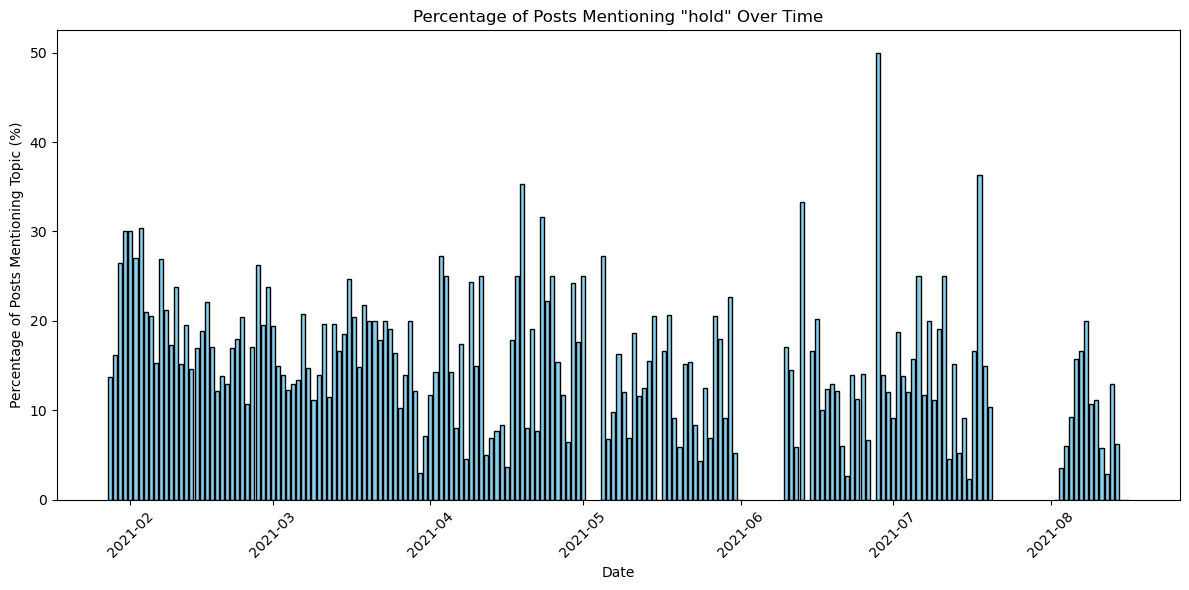

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
body_data['timestamp'] = pd.to_datetime(body_data['timestamp'])

# Define topic
topic = "hold"

# Create a boolean column indicating if the topic is mentioned in a post
body_data['mentions_topic'] = body_data['body'].str.contains(rf'\b{topic}\b', case=False, na=False)

# Extract date
body_data['date'] = body_data['timestamp'].dt.date

# Count how many posts per day (total)
daily_total = body_data.groupby('date').size().reset_index(name='total_posts')

# Count how many posts mention the topic per day
daily_topic = body_data[body_data['mentions_topic']].groupby('date').size().reset_index(name='topic_posts')

# Merge the two DataFrames on 'date'
merged = pd.merge(daily_total, daily_topic, on='date', how='left')

# Fill NaN in topic_posts with 0 (days with no mentions)
merged['topic_posts'] = merged['topic_posts'].fillna(0)

# Compute percentage
merged['percentage'] = (merged['topic_posts'] / merged['total_posts']) * 100

# Sort by highest number of topic_posts
merged = merged.sort_values(by='topic_posts', ascending=False)

# Print the sorted table
print(merged.head(10))

# Plot the percentage over time as a bar chart
plt.figure(figsize=(12,6))
plt.bar(merged['date'], merged['percentage'], color='skyblue', edgecolor='black')
plt.title(f'Percentage of Posts Mentioning "{topic}" Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Posts Mentioning Topic (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
